In [ ]:
#All imported libraries/functions exist here
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import train_test_split
import functools

In [ ]:
covid_confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
county_info = pd.read_csv('abridged_couties.csv')
state_info = pd.read_csv('4.18states.csv')
covid_death = pd.read_csv('time_series_covid19_deaths_US.csv')

Exploratory Data Analysis

---



We'll begin by taking a look at the first five entries of all of the provided datasets.

In [ ]:
covid_confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,5,12,14,15,27,29,32,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5,14,21,23,31,39,51,64,79,100,127,174,239,286,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,6,6,7,17,17,17,19,22,23,30,30,30,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53


This dataset contains information about a particular county in the United States, which can be identified using the UID or FIPS (Federal Information Processing Number) and notes the cumulative number of confirmed cases from 1/22/20 to 4/18/20. The granularity of the dataframe goes down to each particular county, but also includes a 'Province_State' column and 'Country_Region' that can be used to increase the granularity if we choose to group by those columns.

In [ ]:
county_info.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

This dataset also includes the Federal Information Processing Number for all counties in the US, labeled 'countyFIPS', and various information about that particular county, such as its population ('PopulationEstimate2018'), population density ('PopulationDensityperSqMile2010'), number of Hospitals ('#Hospitals), breakdown of sex and age, date in which certain policies such as shelter in place ('stay at home') orders were announced by Gregorian date format, and Democrat to Republican ratio (dem_to_rep_ratio).

In [ ]:
state_info.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


The main distinction between this dataset and the others is that the granularity of this dataframe goes only to the State level, but also includes data for countries beyond the U.S. such as Canada and China. This dataframe includes features found in other datasets, such as confirmed cases ('Confirmed'), number of deaths ('Deaths'), and other features that control for population such as Incident Rate ('Incident_Rate') and Testing Rate ('Testing_Rate'). We used https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data to gather information on all the columns and their descriptions.

In [ ]:
covid_death.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3


Similar to covid_confirmed, covid_death contains the cumulative number of deaths for counties within the United States from 1/22/20 to 4/18/20. Unlike covid_confirmed, covid_death contains a column that contains the population ('Population') of that particular county.

Now that we've gathered a general understanding of what each dataset represents, we'll start to clean the data a bit before we start to think about what sort of model we'd like to create and what questions we would like to ask in particular.

Data Cleaning: The bottom cell begins to clean some of our data. However, a lot of cleaning also occurs during EDA, which will be marked with (DC)

In [ ]:
# Removes rows without a numerical FIPS
county_cleaned = county_info[~county_info.countyFIPS.isin(['City1', 'City2'])] # City1 and City2 have no data within that row, so we've filtered it out.
confirmed_cleaned = covid_confirmed[~covid_confirmed.FIPS.isna()] # Only two rows in covid_confirmed and covid_death had no FIPS number, so we've filtered those out.
death_cleaned = covid_death[~covid_death.FIPS.isna()]

# Converts FIPS column into int type for when merging on this primary key.
county_cleaned.loc[:,'countyFIPS'] = county_cleaned.countyFIPS.astype(int)
confirmed_cleaned.loc[:,'FIPS'] = confirmed_cleaned.FIPS.astype(int)
death_cleaned.loc[:,'FIPS'] = death_cleaned.FIPS.astype(int)

# Renames 'countyFIPS' in county_cleaned to 'FIPS' for grouping purposes.
county_cleaned = county_cleaned.rename(columns = {'countyFIPS': 'FIPS'})

# Cleaned out all the countries that aren't US or China (DC)
countries_cleaned = state_info[state_info.Country_Region.isin(['US', 'China'])]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


We'll start by asking the following question: How does the United States compare against China in terms of # of Confirmed Cases, Deaths, Recovered, and Incident Rate?

Text(0, 0.5, 'Number of Confirmed Cases')

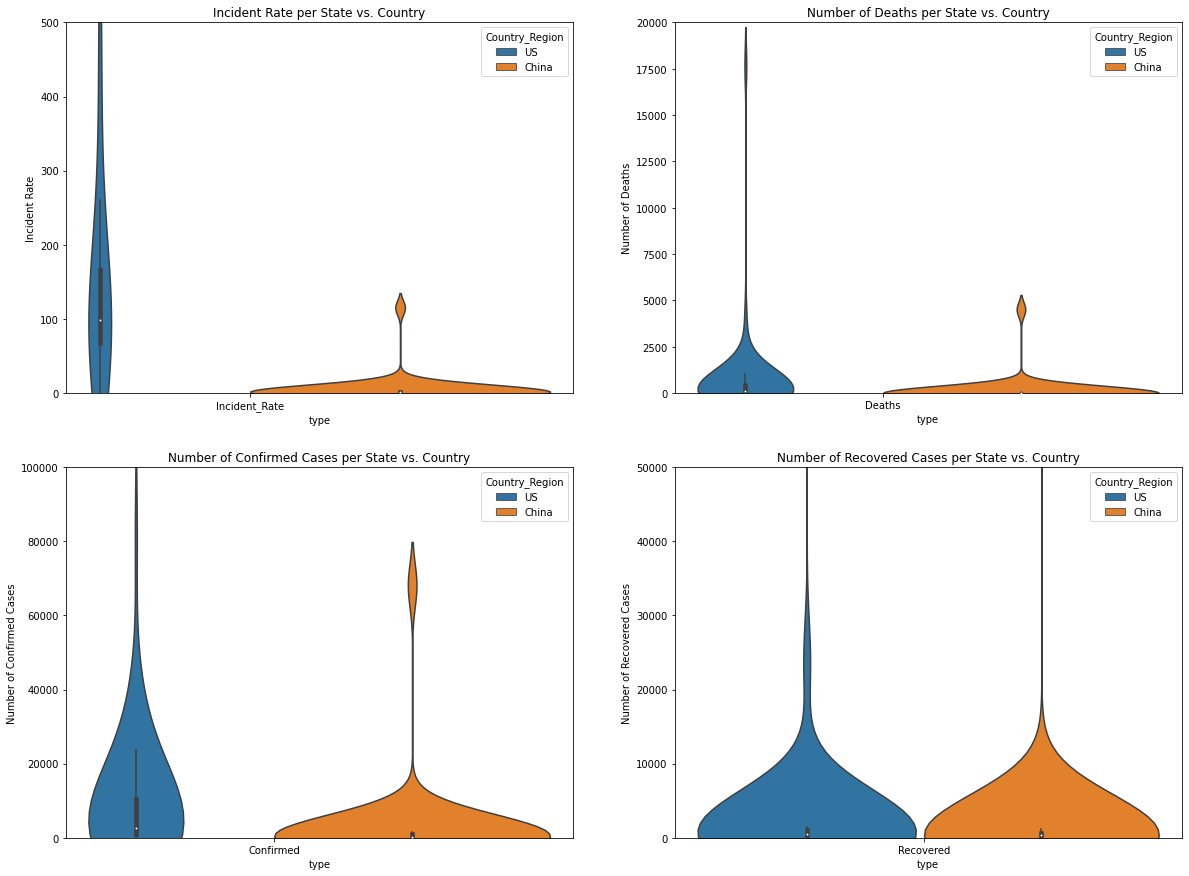

In [ ]:
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))

countries_melted_incident = pd.melt(countries_cleaned, id_vars=['Country_Region'], value_vars=['Incident_Rate'], var_name='type', value_name='value')
sns.violinplot(x="type", y="value",data= countries_melted_incident, hue = 'Country_Region', ax = axes[0, 0])

countries_melted_deaths = pd.melt(countries_cleaned, id_vars=['Country_Region'], value_vars=['Deaths'], var_name='type', value_name='value')
sns.violinplot(x="type", y="value",data= countries_melted_deaths, hue = 'Country_Region', ax = axes[0, 1])

countries_melted_recovered = pd.melt(countries_cleaned, id_vars=['Country_Region'], value_vars=['Recovered'], var_name='type', value_name='value')
sns.violinplot(x="type", y="value",data= countries_melted_recovered, hue = 'Country_Region', ax = axes[1, 1])

countries_melted_confirmed = pd.melt(countries_cleaned, id_vars=['Country_Region'], value_vars=['Confirmed'], var_name='type', value_name='value')
sns.violinplot(x="type", y="value",data= countries_melted_confirmed, hue = 'Country_Region', ax = axes[1, 0])

axes[0, 0].set_title('Incident Rate per State vs. Country')
axes[0, 1].set_title('Number of Deaths per State vs. Country')
axes[1, 1].set_title('Number of Recovered Cases per State vs. Country')
axes[1, 0].set_title('Number of Confirmed Cases per State vs. Country')
axes[0, 0].set_ylim(0, 500)
axes[0, 1].set_ylim(0, 20000)
axes[1, 1].set_ylim(0, 50000)
axes[1, 0].set_ylim(0, 100000)
axes[0, 0].set_ylabel(ylabel = 'Incident Rate')
axes[0, 1].set_ylabel(ylabel = 'Number of Deaths')
axes[1, 1].set_ylabel(ylabel = 'Number of Recovered Cases')
axes[1, 0].set_ylabel(ylabel = 'Number of Confirmed Cases')

As a reminder, Incident Rate is defined as Number of Confirmed Cases per 100,000 people. Therefore, we can observe a similar distribution in 'Incident Rate per County vs. Country and Number of Confirmed Cases per County vs. Country'.

Confirmed cases in the US compared to confirmed cases in China are distributed more evenly throughout the violin plot (which is why it's not as wide as the other plot). The area to the left and right of the line down the middle of the violin plots represents the distribution shape of the data. Wider sections of these plots represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability. 

For China, there is a clear outlier in all of the distributions. Looking at the data for China, there is a clear outlier for the state/province Hubei. According to Johns Hopkins, Wuhan, a city in Hubei, is the point of origination of where the Coronvirus started.
https://coronavirus.jhu.edu/data/hubei-timeline

What we can then conclude is that the United States is struggling to contain the spread from one state to another, as the distributions for Deaths, Incident Rate, and Confirmed Cases for the United States are all relatively evenly spread compared to China. This is in line with certain assumptions about both governments and their ability to enforce and maintain policies such as shelter in place, limited public gatherings, and closing of schools, where we will investigate later in EDA. 

What we cannot conclude (limitations) is a comparison about the total number of confirmed cases, deaths, or recovered cases between the United States and China because that would require a different visualization. However, the violin plot indicates that there is wider community spread in the US compared to China.



Question: Does the political leaning of a particular county have correlation with its cumulative number of cases, and does the cumulative number of cases have an impact on when emergency protocol such as shelter in place begins?

In [ ]:
# We will examine the correlation, if any, between dem_to_rep_ratio and number of confirmed cases

# Merges number of confirmed cases and political affiliation ratio into one dataframe
pol_confirmed = pd.DataFrame.merge(county_cleaned[['FIPS', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010']], confirmed_cleaned[['FIPS', '4/18/20']], how = 'inner', on = 'FIPS')
#Gallup Polls to apply Likert scale: https://news.gallup.com/poll/203117/gop-maintains-edge-state-party-affiliation-2016.aspx

# Influenced from Gallup Poll: Solid: Party has >= 10 point advantage, Competitive: <10 point advantage

# Looking at the data, it looks like a lot of Alaskan counties would be filtered out because they're missing ratios.
# http://www.elections.alaska.gov/results/16GENR/data/results.htm gives us a Democrat to Republican ratio of 0.71274948 (DC).

AK_no_info = pol_confirmed[(pol_confirmed['FIPS'] >= 2050) & (pol_confirmed['FIPS'] <= 2290)]['dem_to_rep_ratio']
AK_indexes = AK_no_info.index # Gathers index of all alaskan_counties with no dem_to_rep ratio
pol_confirmed.iloc[AK_indexes, pol_confirmed.columns.get_loc('dem_to_rep_ratio')] = 0.71274948

# Cleans 'dem_to_rep_ratio' to filter NA values
pol_confirmed = pol_confirmed[~pol_confirmed['dem_to_rep_ratio'].isna()]

# Cleans 'PopulationDensityperSqMile2010 to filter NA values
pol_confirmed = pol_confirmed[~pol_confirmed['PopulationDensityperSqMile2010'].isna()]

# Renames certain columns for convenient use
pol_confirmed.rename(columns = {'dem_to_rep_ratio': 'Political Leaning', '4/18/20':'Cumulative Cases up to 4/18/20', 'PopulationDensityperSqMile2010':'Population Density'}, inplace = True)

(0.0, 2500.0)

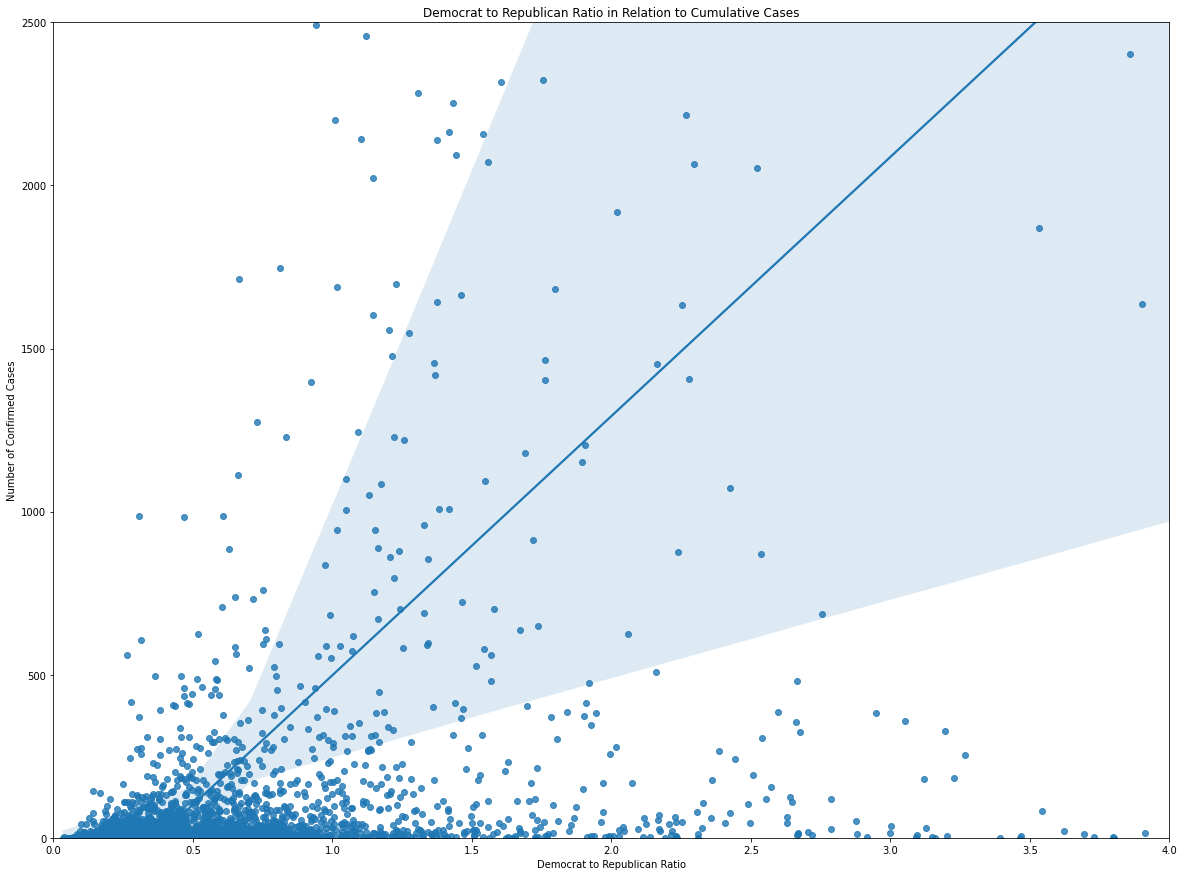

In [ ]:
plt.figure(figsize = (20, 15))
sns.regplot(pol_confirmed['Political Leaning'], pol_confirmed['Cumulative Cases up to 4/18/20'])
plt.xlabel('Democrat to Republican Ratio')
plt.ylabel('Number of Confirmed Cases')
plt.title('Democrat to Republican Ratio in Relation to Cumulative Cases')
plt.xlim(0, 4)
plt.ylim(0, 2500)

The linear regression line shows that there are higher numbers of confirmed cases in counties that lean Democrat.

Text(0.5, 1.0, 'County Political Leaning vs. Mean # of Cases per County until 4/18/20')

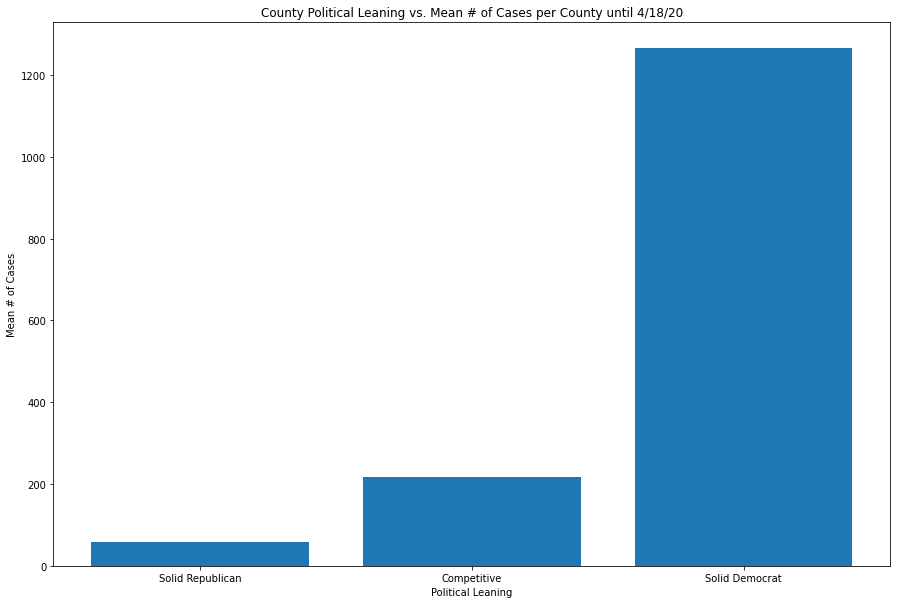

In [ ]:
# Classifies political leaning value using a Likert scale
def labelPolitical(x):
  if x <= 0.9:
    return 'Solid Republican'
  elif x >= 1.1:
    return 'Solid Democrat'
  return 'Competitive'

# Creates new column containing political leaning classifications
pol_confirmed['Political Leaning Named'] = pol_confirmed['Political Leaning'].apply(lambda x: labelPolitical(x))

# Group by political leaning aggregating on the mean
grouped = pol_confirmed.groupby('Political Leaning Named').agg(np.mean).sort_values(by = 'Cumulative Cases up to 4/18/20', ascending = True)

plt.figure(figsize=(15,10))
plt.bar(grouped.index, grouped['Cumulative Cases up to 4/18/20'])
plt.xlabel('Political Leaning')
plt.ylabel('Mean # of Cases')
plt.title('County Political Leaning vs. Mean # of Cases per County until 4/18/20')

We see that political affiliation correlates with the number of confirmed cases in a a county. We want to explore specifically how policies differ between counties of differing political affiliation. The most common policy is shelter in place. I will plot how political affiliation influences the start date of shelter in place for counties.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


([<matplotlib.axis.XTick at 0x7f2b92f5d400>,
 [Text(0, 0, '2020-03-19'),
  Text(0, 0, '2020-03-21'),
  Text(0, 0, '2020-03-22'),
  Text(0, 0, '2020-03-23'),
  Text(0, 0, '2020-03-24'),
  Text(0, 0, '2020-03-25'),
  Text(0, 0, '2020-03-26'),
  Text(0, 0, '2020-03-27'),
  Text(0, 0, '2020-03-28'),
  Text(0, 0, '2020-03-30'),
  Text(0, 0, '2020-03-31'),
  Text(0, 0, '2020-04-01'),
  Text(0, 0, '2020-04-02'),
  Text(0, 0, '2020-04-03'),
  Text(0, 0, '2020-04-04'),
  Text(0, 0, '2020-04-06'),
  Text(0, 0, '2020-04-07')])

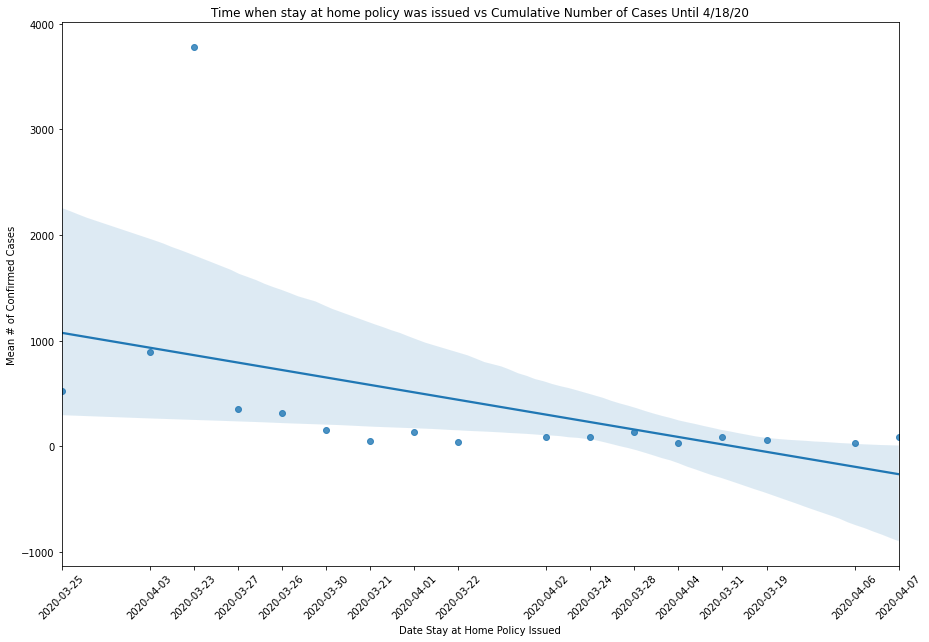

In [ ]:
# Filters out NaN values from 'stay at home' column
county_stayathome_cleaned = county_cleaned[~county_cleaned['stay at home'].isna()]

# Converting Gregorian ordinals to timestamps
county_stayathome_cleaned['stay at home date'] = county_stayathome_cleaned['stay at home'].astype(int).apply(pd.Timestamp.fromordinal).astype(str).apply(lambda x: x[:10])

date_vs_confirmed = pd.DataFrame.merge(county_stayathome_cleaned[['FIPS', 'stay at home date', 'stay at home', 'PopulationEstimate2018']], confirmed_cleaned[['FIPS', '4/18/20']], how = 'inner', on = 'FIPS')

# Group by date instituted for stay at home policy, aggregates on average number of cases 
date_vs_confirmed_grouped = date_vs_confirmed.groupby('stay at home date').agg(np.mean)

# Plots stay at home dates vs dem_to_rep_ratio
plt.figure(figsize=(15,10))
sns.regplot(date_vs_confirmed_grouped['stay at home'], date_vs_confirmed_grouped['4/18/20'])
plt.title('Time when stay at home policy was issued vs Cumulative Number of Cases Until 4/18/20')
plt.xlabel('Date Stay at Home Policy Issued')
plt.ylabel('Mean # of Confirmed Cases')
plt.xticks(date_vs_confirmed['stay at home'].drop_duplicates(keep = 'first'), date_vs_confirmed_grouped.index, rotation = 45)

When looking at the correlation between the date of stay at home and # of Confirmed Cases, we can conclude that the date that stay at home policies were initiated has a correlation with the number of confirmed cases due to the relatively small area of the blue shaded region that captures 95% of our data.

Some may look at this graph and conclude that Stay at Home is ineffective because areas that begin Stay at Home tend to have a higher # of confirmed cases. We will explain in our next visualization why that is not necessarily true.

We want to also explore other factors that might also influence the start date of shelter in place. Next, we will examine whether there is a correlation between the time of increase of coronavirus cases and the shelter in place date for counties.

https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html

Why group by time of shelter in place policy and not by state?

Stay at home orders are not necessarily by state. Individual counties within one state might have different dates for when the policy was issued. Therefore, if we want to group the data for a more concise visualization, we should group by the date each county instituted its stay at home policy. This is because grouping by state by taking the median or mean would skew the data. Some counties started shelter in place way earlier than other counties in the same state, thereby also having more confirmed cases. On the other hand, the data amoung counties that issued the order at the same date would most likely bear similar data. This is because the counties would have just started seeing an increase of coronavirus cases.

Nonetheless, we are exploring the relationship between the start date of shelter in place and the number of coronavirus cases before that date. It would only make sense to group by the start date of shelter in place and not by state, which contains counties with differing start dates.

Next Question: How effective are shelter in place policies when comparing counties that started earlier than others?

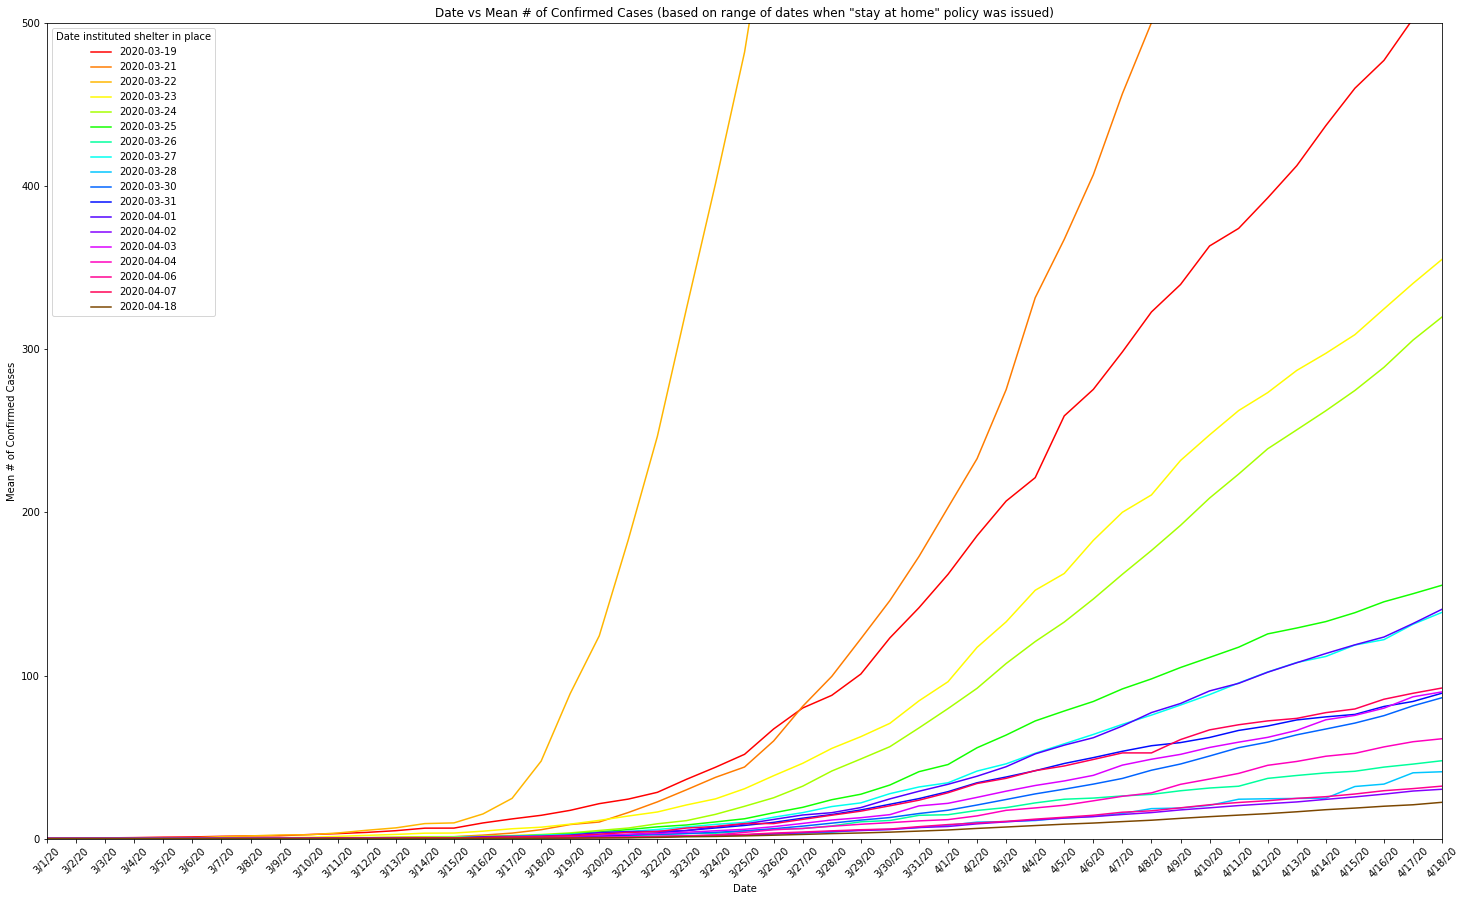

In [ ]:
# Merges stay at home and number of confirmed to the same dataframe
home_confirmed = pd.DataFrame.merge(county_cleaned[['FIPS', 'stay at home']], confirmed_cleaned.drop(['UID','iso2','iso3','code3','Admin2','Province_State','Country_Region','Lat','Long_','Combined_Key'], axis = 1), how = 'inner', on = 'FIPS')

# Replaced all NAN values with Gregorial ordinal 737533.0, which corresponds to 4/18
home_confirmed['stay at home'] = home_confirmed['stay at home'].fillna(737533.0)

# Converting Gregorian ordinals to timestamps
home_confirmed['stay at home date'] = home_confirmed['stay at home'].astype(int).apply(pd.Timestamp.fromordinal).astype(str).apply(lambda x: x[:10])

# Group by date instituted for stay at home policy, aggregates on average number of cases 
home_confirmed_grouped = home_confirmed.groupby('stay at home date').mean().drop(['FIPS'], axis = 1)

# Obtain list of dates when stay at home was instituted
home_dates = home_confirmed_grouped.index
# Plots confirmed cases over time, grouped by date instituted shelter in place
plt.figure(figsize=(25,15))
colors = ['#FF0000','#FF7C00','#FFB600','#FFFB00','#A6FF00','#13FF00','#00FF9D','#00FFF0','#00C5FF','#0064FF','#000CFF','#5100FF','#8300FF','#DC00FF','#FF00BD','#FF0091','#FF0053', '#7C4700']
[plt.plot(home_confirmed_grouped.columns, home_confirmed_grouped.iloc[x, :], color = colors[x]) for x in range(len(home_dates))]
plt.xticks(ticks = home_confirmed_grouped.columns, rotation=45)
plt.title('Date vs Mean # of Confirmed Cases (based on range of dates when "stay at home" policy was issued)')
plt.xlim("3/1/20","4/18/20") 
plt.ylim(0,500)
plt.xlabel('Date')
plt.ylabel('Mean # of Confirmed Cases')
plt.legend(home_dates, title = 'Date instituted shelter in place')


Grouping by timestamp poses an ethical concern. A county with a small number of cases might be aggregated with a county containing a large number of cases. This will be giving the small county a lower weight in the average number of cases at a particular timestamp.

Like above, this plot DOES NOT show that the later shelter in place was instituted, the higher mortality, as one might assume. In fact, we see the contrary here. This is because shelter in place is a response to existing cases in particular counties. Therefore, if the coronavirus is already present in those counties, we expect the number of cases to increase at those locations first. Also, the effectiveness of shelter in place will not be noticed soon after the start of the policy since newly confirmed cases may be cases from before the date. There is a discrepency between when an individual catches the virus versus when the individual reports having caught the virus.

However, this graph is difficult to digest upon first glance due to the presence of many curves. Therefore, we will group the curves by mid-late March (3/19-3/24), late March (3/25-3/31) and early April (4/1-4/7).

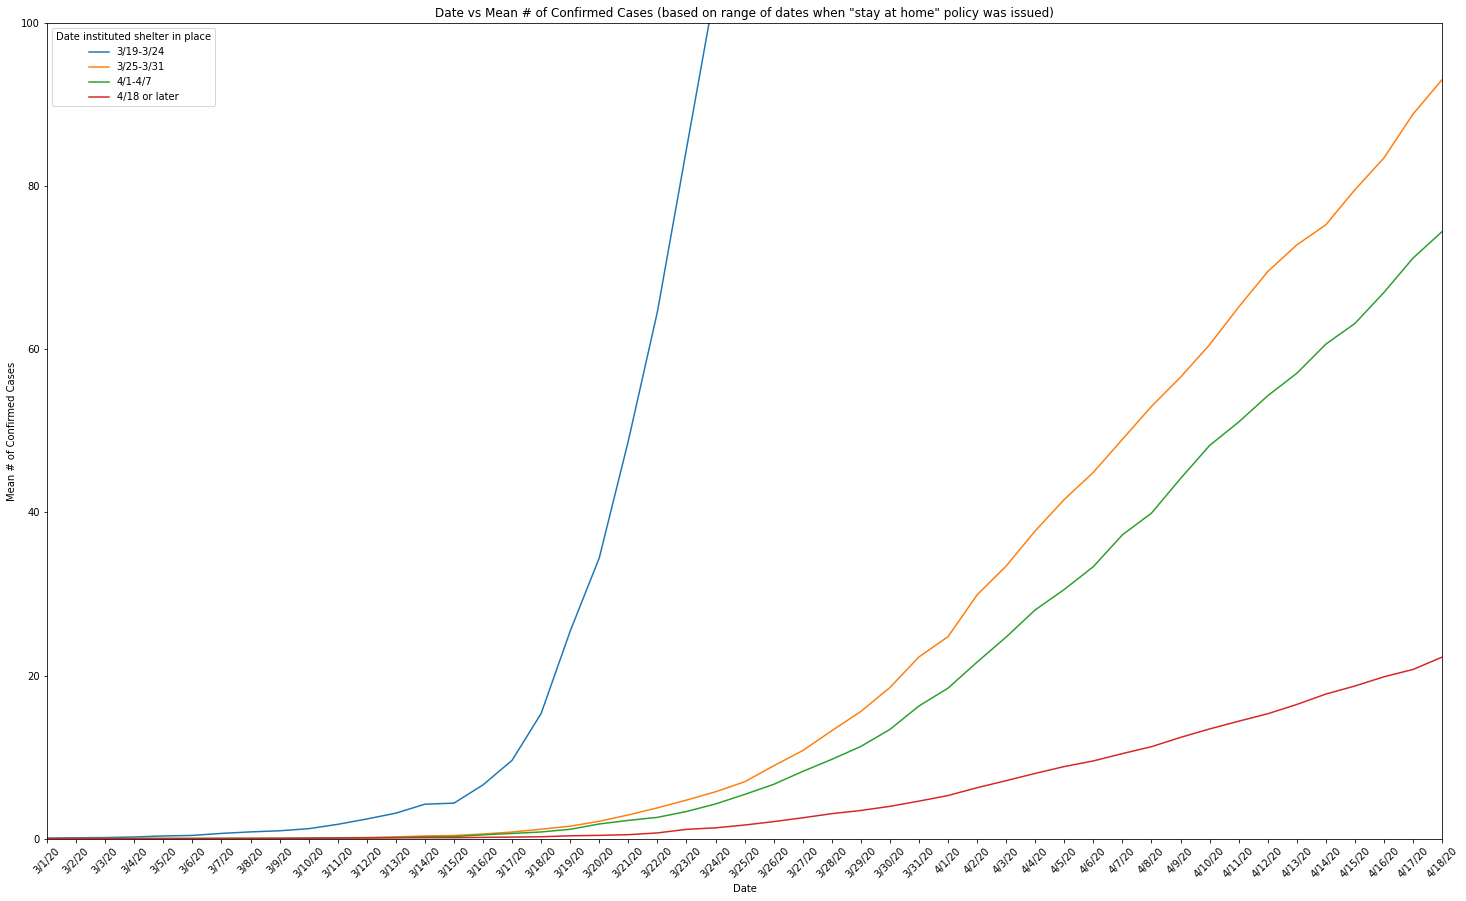

In [ ]:
# Group by range of dates instituted for stay at home policy, aggregates on average number of cases 
date_range = ['3/19-3/24']*5 + ['3/25-3/31']*6 + ['4/1-4/7']*6 + ['4/18 or later']
home_confirmed_grouped['date_range'] = date_range
home_confirmed_grouped_byRange = home_confirmed_grouped.groupby('date_range').mean()

# Obtain list of dates when stay at home was instituted
home_dates = home_confirmed_grouped_byRange.index

# Plots confirmed cases over time, grouped by date instituted shelter in place
plt.figure(figsize=(25,15))
[plt.plot(home_confirmed_grouped_byRange.columns, home_confirmed_grouped_byRange.loc[x, :]) for x in home_dates]
plt.xticks(ticks = home_confirmed_grouped_byRange.columns, rotation=45)
plt.title('Date vs Mean # of Confirmed Cases (based on range of dates when "stay at home" policy was issued)')
plt.xlim("3/1/20","4/18/20") 
plt.ylim(0,100)
plt.xlabel('Date')
plt.ylabel('Mean # of Confirmed Cases')
plt.legend(home_confirmed_grouped_byRange.index, title = 'Date instituted shelter in place')

We see that the curves showing increase later in time are the counties that shelter in place are being issued at a later date. Therefore, we can see here that the shelter in place is only instituted after having noted a sizeable number of confirmed cases in the counties.

We can also tell from this graph, how many cases there were for a county to finally issue the stay at home policy. For example, for a county that issued the policy during 4/1-4/7, there were around 20 to 40 cases in that county up to that date.

We also noticed how the counties that issued the stay at home policy earlier (3/19-3/24) has a drastically larger number of cases (30 to 100) until the policy was instituted. This is might be because the earlier counties served as a precedence for later counties to also shelter in place. Therefore, the later counties are more prone to shelter in place at an earlier stage of cases, knowing that other counties have already done so. For example, Minnesota is able to reference other states to detail how their own shelter in place order would look like.
https://www.mprnews.org/story/2020/03/21/what-would-a-shelterinplace-order-look-like-in-minnesota

However, we will explore another possibility: population size causes the drastically larger number of cases for the counties that issued the policy earlier (IN APPENDIX BELOW: NOT USED)

MODEL CREATION

In [ ]:
#We will be taking a function for Root Mean Squared Error and Cross-validation score from Lab 7

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        y_predicted = model.predict(split_X_valid)
        error = rmse(y_predicted, split_Y_valid)


        validation_errors.append(error)
        
    return np.mean(validation_errors)

def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
    """
    return np.sqrt(np.mean((actual_y-predicted_y) ** 2))


In [ ]:
# Returns a list of all combinations of the given features
def combination(features):
  combo = []
  for L in range(1, len(features)+1):
     for subset in combinations(features, L):
          combo.append(subset)
  combo = [[x for x in list(N)] for N in combo]
  return combo

# Returns a list of CV errors for all feature combinations
def cvError(combo, model, X_train, Y_train):
  errors = []
  for N in combo:
     print(f"Trying feature(s): {N}")
     # Compute the cross validation error
     error = compute_CV_error(model, X_train.loc[:, N], Y_train)
     print("\tRMSE:", error)
     errors.append(error)
  return errors

In [ ]:
# Initialize linear model
linearmodel = linear_model.LinearRegression()

# Merge total number of cases and features into same dataframe
county_confirmed = pd.DataFrame.merge(county_cleaned, confirmed_cleaned[['FIPS','4/4/20','4/18/20']], how = 'inner', on = 'FIPS')

# Define features and response variables
county_confirmed_filtered = county_confirmed.copy()
selected_features = ['PopulationEstimate2018','PopulationDensityperSqMile2010','SVIPercentile', '4/4/20','dem_to_rep_ratio', 'stay at home', 'MedianAge2010', '#Hospitals', 'PopFmle75-842010', 'PopMale75-842010']
for x in selected_features:
  if x != 'stay at home':
    county_confirmed_filtered = county_confirmed_filtered[~county_confirmed_filtered[x].isna()]
  elif x == 'stay at home':
    county_confirmed_filtered['stay at home'] = county_confirmed_filtered['stay at home'].fillna(737533.0)
X = county_confirmed_filtered[selected_features]
Y = county_confirmed_filtered['4/18/20'] - county_confirmed_filtered['4/4/20']


In [ ]:
#Taken from lab08
def normalize(data):
    '''
    Args:
        data : a dataframe
    Returns:
        the normalized version of input data with NAN values filled with 0's
    '''
    new_data = data.copy()
    new_data = (new_data - np.mean(new_data))/np.std(new_data)
    new_data = new_data.fillna(0)
    return new_data

In [ ]:
# Split into training and test sets and normalize the data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 52)
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

# Obtain all combinations of the given features
combos = combination(selected_features)
# Calculate the CV error for the each feature combination
errors = cvError(combos, linearmodel, X_train_normalized, Y_train)

Trying feature(s): ['PopulationEstimate2018']
	RMSE: 625.5280838536212
Trying feature(s): ['PopulationDensityperSqMile2010']
	RMSE: 728.8400784246923
Trying feature(s): ['SVIPercentile']
	RMSE: 737.2784134932992
Trying feature(s): ['4/4/20']
	RMSE: 252.58353610855525
Trying feature(s): ['dem_to_rep_ratio']
	RMSE: 722.5511623984244
Trying feature(s): ['stay at home']
	RMSE: 730.5915062672636
Trying feature(s): ['MedianAge2010']
	RMSE: 734.0594219203095
Trying feature(s): ['#Hospitals']
	RMSE: 638.490184727153
Trying feature(s): ['PopFmle75-842010']
	RMSE: 597.0567012214791
Trying feature(s): ['PopMale75-842010']
	RMSE: 609.3626155671981
Trying feature(s): ['PopulationEstimate2018', 'PopulationDensityperSqMile2010']
	RMSE: 640.4262069318513
Trying feature(s): ['PopulationEstimate2018', 'SVIPercentile']
	RMSE: 625.6787727141364
Trying feature(s): ['PopulationEstimate2018', '4/4/20']
	RMSE: 242.1950587824852
Trying feature(s): ['PopulationEstimate2018', 'dem_to_rep_ratio']
	RMSE: 625.47660

In [ ]:
# Identify the feature(s) that give the lowest and highest errors
best_num_features = np.argmin(errors, axis = 0) + 1
best_err = compute_CV_error(linearmodel, X_train_normalized.loc[:, combos[best_num_features - 1]], Y_train)*100 / np.mean(Y_train)
worst_num_features = np.argmax(errors, axis = 0) + 1
just_date_error = compute_CV_error(linearmodel, X_train_normalized.loc[:, ['4/4/20']], Y_train)*100 / np.mean(Y_train)
worst_err = compute_CV_error(linearmodel, X_train_normalized.loc[:, combos[worst_num_features - 1]], Y_train)*100 / np.mean(Y_train)
print(f"The lowest CV error was {best_err}%, which came from using these feature(s): {combos[best_num_features - 1]}.")
print(f"The highest CV error was {worst_err}% which came from using these feature(s): {combos[worst_num_features - 1]}.")
print(f"CV Error with just the date alone was {just_date_error}%.")

The lowest CV error was 197.47373150633265%, which came from using these feature(s): ['PopulationDensityperSqMile2010', '4/4/20', 'dem_to_rep_ratio', 'MedianAge2010', 'PopFmle75-842010', 'PopMale75-842010'].
The highest CV error was 611.3359195562614% which came from using these feature(s): ['SVIPercentile'].
CV Error with just the date alone was 209.43701251209782%.


We apply cross validation to prevent overfitting when selecting features.

We will now test the accuracy of our trained model by calculating the R^2 value on the training set and by calculating error on the test set.

In [ ]:
X_train_best = X_train_normalized[combos[best_num_features - 1]]

linearmodel.fit(X_train_best, Y_train)

training_accuracy = linearmodel.score(X_train_best, Y_train)
print(f"Training Accuracy: {training_accuracy * 100}%")

Y_hat = linearmodel.predict(X_test_normalized[combos[best_num_features - 1]])
test_error = rmse(Y_test, Y_hat)*100 / np.mean(Y_test)
print(f"The test error is {test_error}%.")

Training Accuracy: 92.06705675332464%
The test error is 1026.314388785715%.


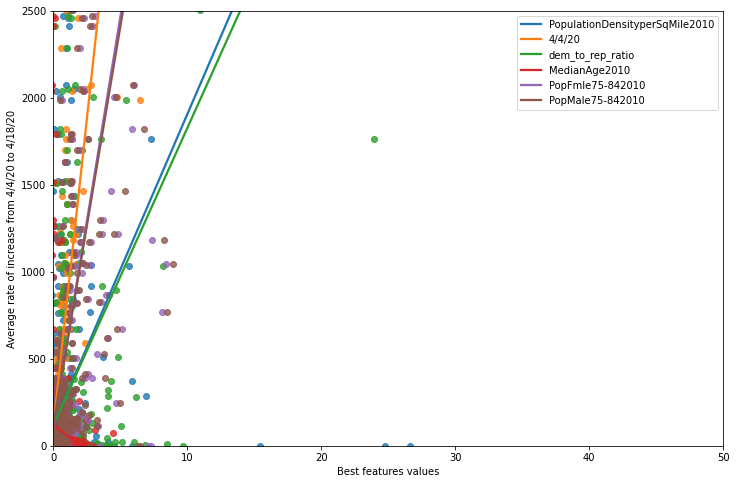

In [ ]:
# Plot the best features against the total confirmed cases to visualize their correlations
plt.figure(figsize = (12, 8))
[sns.regplot(X_train_best.iloc[:, x], Y_train, ci = 0) for x in range(len(X_train_best.columns))]
plt.xlabel('Best features values')
plt.ylabel('Average rate of increase from 4/4/20 to 4/18/20')
plt.xlim(0, 50)
plt.ylim(0, 2500)
plt.legend(combos[best_num_features - 1])

Attempting Lasso

In [ ]:
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X)) ** 2))

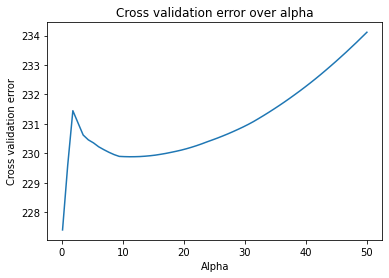

The best alpha value is 0.1
Cross validation error for the best alpha value is 227.3996494097872


In [ ]:
X_train_normalized = StandardScaler().fit_transform(X_train)
X_test_normalized = StandardScaler().fit_transform(X_test)

#below code is from lab08 
alpha_arr = np.linspace(0.1, 50, 60)
cv_errors = []
model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Lasso(max_iter = 1000000))])

for alpha in alpha_arr:
    model.set_params(LinearModel__alpha=alpha)

    # compute the cross validation error
    cv_error = np.mean(cross_val_score(model, X_train_normalized, Y_train, scoring = rmse_score, cv = 5))
    
    cv_errors.append(cv_error)
    
best_alpha_lasso = alpha_arr[np.argmin(cv_errors)]

plt.plot(alpha_arr, cv_errors)
plt.title('Cross validation error over alpha')
plt.xlabel('Alpha')
plt.ylabel('Cross validation error')
plt.show()

print(f"The best alpha value is {best_alpha_lasso}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

In [ ]:
lasso_model = Lasso(max_iter=1000000, alpha = best_alpha_lasso)

# Fit `lasso_model`
lasso_model.fit(X_train_normalized, Y_train)

# Error of prediction
test_RMSE = rmse_score(lasso_model, X_test_normalized, Y_test)


print('test RMSE for Lasso Model:', test_RMSE)

test RMSE for Lasso Model: 1755.0085171678


Per an instructor's recommendations on the Data100 Piazza, below is an appendix with different visualizations we have created during EDA and decided not to use in our final submission.

# **-----------------APPENDIX-----------------**

We now divide the number of confirmed cases by the population size because some counties have larger populations than others. We want to check whether shelter in place is instituted based on the raw number of confirmed cases or with consideration of the population size of a county. A county might deem a large number of cases as small relative to its large population size.

Furthermore, a larger population might cause higher density in a county, so the rate of spread of the cornavirus is much greater than counties with a smaller population. Therefore, during preparation for shelter in place, the number of cases are increasing at an alarming rate, having a significant amount of cases when the policy is eventually issued. There is a gap of time between planning to shelter in place and actually instituting the policy. It is recommended for governors to give time and notice the public to prepare before actually instituting shelter in place (p.3) : 
https://www.nga.org/wp-content/uploads/2018/08/GovGuideMassEvacuation.pdf

The counties that instituted shelter in place earlier are no longer displaying relatively high values for the number of confirmed case before the date of policy enforcement. Therefore, the large number of confirmed cases before the start of shelter in place for earlier counties are due to population size.

This graph shows that for each range of dates, shelter in place is enforced in a county when there are approximately 0.0001 to 0.0003 number of cases per capita.


Further exploration: We have discovered that there is a correlation between when the number of cases starts to increase and the date of when shelter in place is enforced at a particular county. However, we can also explore the number of deaths and discern whether this is even a better indicator on when shelter in place will be issued.

The group 4/1-4/7 occurs at a later date than group 3/25-3/31, but it still significantly increases at around the same date, if not earlier. There is no correlation between when the number of deaths starts to increase and the date of when shelter in place is enforced at a particular county. Therefore, utilizing the number of cases instead provides the best indicator of when shelter in place is enforced at a particular county.

This makes sense because there are only a small number of deaths up to the start of shelter in place and the outcomes of the affected have not been determined yet. Therefore, it is reasonable to look at the number of confirmed cases rather than the number of deaths to decide when to enforce shelter in place.

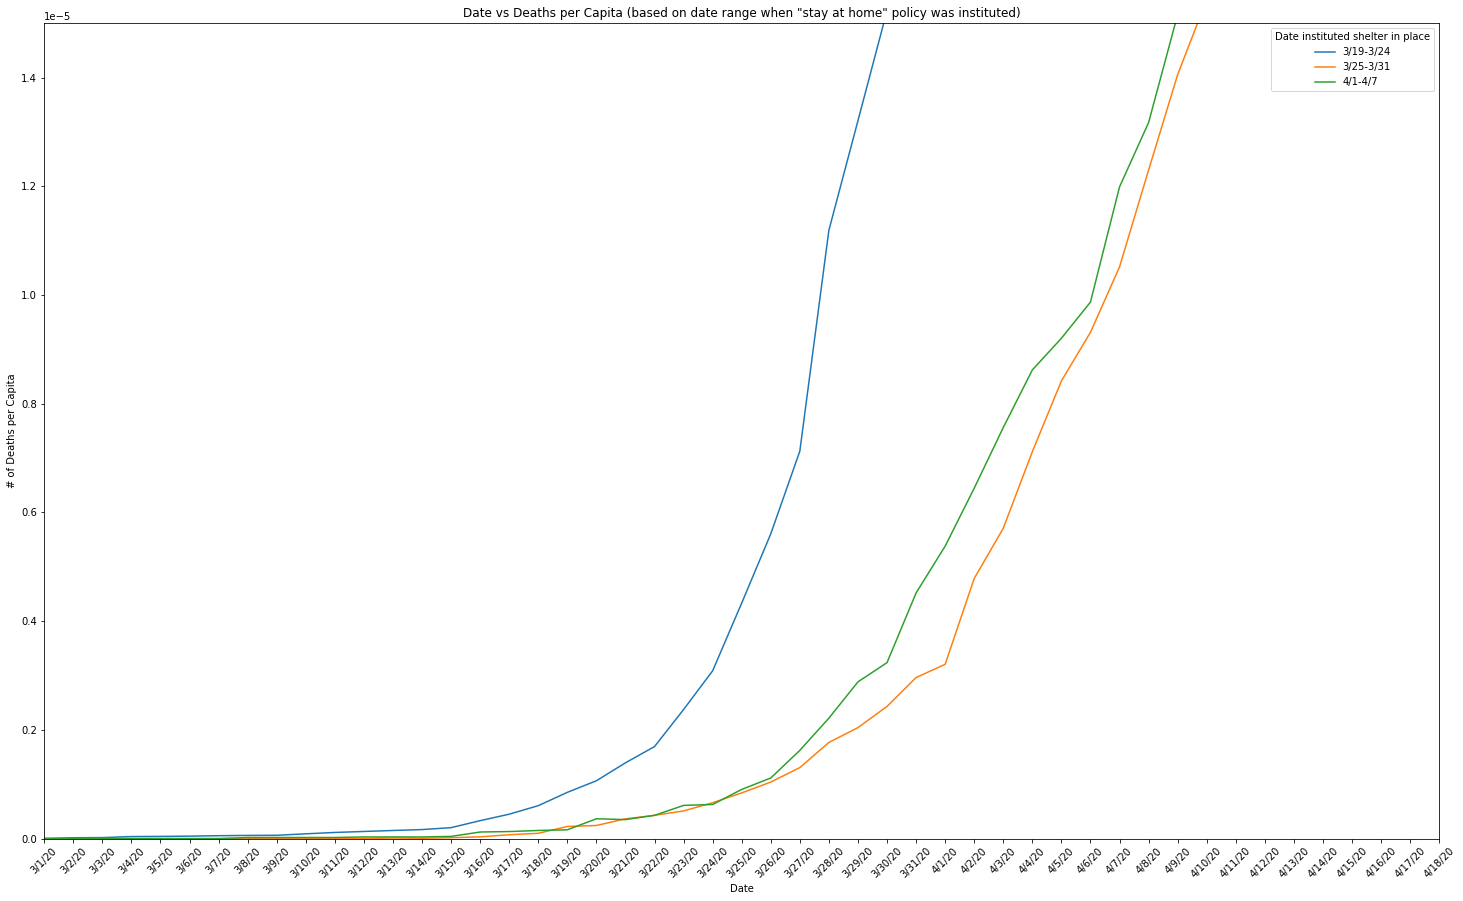

In [ ]:
# Merges stay at home, population and number of deaths to the same dataframe
home_death = pd.DataFrame.merge(county_cleaned[['FIPS', 'stay at home']], death_cleaned.drop(['UID','iso2','iso3','code3','Admin2','Province_State','Country_Region','Lat','Long_','Combined_Key'], axis = 1), how = 'inner', on = 'FIPS')

# Removes all NaN values from home_death dataframe
home_death = home_death[~home_death['stay at home'].isna()]

# Converting Gregorian ordinals to timestamps
home_death['stay at home date'] = home_death['stay at home'].astype(int).apply(pd.Timestamp.fromordinal).astype(str).apply(lambda x: x[:10])

# Group by date instituted for stay at home policy, aggregates on average number of deaths 
home_death_grouped = home_death.groupby('stay at home date').mean().drop(['FIPS'], axis = 1)

# Group by range of dates instituted for stay at home policy, aggregates on average number of deaths 
date_range = ['3/19-3/24']*5 + ['3/25-3/31']*6 + ['4/1-4/7']*6
home_death_grouped['date_range'] = date_range
home_death_grouped_byRange = home_death_grouped.groupby('date_range').mean()

# Plots 'stay at home' policy vs number of deaths by county
plt.figure(figsize=(25,15))

# Obtain list of dates when stay at home was instituted
home_dates = home_death_grouped_byRange.index

# Divide each deaths count by population
home_death_grouped_byRange = home_death_grouped_byRange.apply(lambda x: x / home_death_grouped_byRange['Population'])
home_death_grouped_byRange.drop('Population', axis = 1, inplace = True)

# Plots deaths over time, grouped by date instituted shelter in place
[plt.plot(home_death_grouped_byRange.columns, home_death_grouped_byRange.loc[x, :]) for x in home_dates]
plt.xticks(ticks = home_death_grouped_byRange.columns, rotation=45)
plt.title('Date vs Deaths per Capita (based on date range when "stay at home" policy was instituted)')
plt.xlim("3/1/20","4/18/20") 
plt.ylim(0,.000015)
plt.xlabel('Date')
plt.ylabel('# of Deaths per Capita')
plt.legend(home_death_grouped_byRange.index, title = 'Date instituted shelter in place')

We will explore how the dates of other policies instituted correspond with when shelter in place is enforced at a particular county. However, we will not include the ban on '>50 getherings' because this is too distant from the shelther in place date. On the other hand, the recent policies can predict that shelter in place will occur soon after the date they are issued.

I will now create create a model to predict stay at home date using the features mentioned above.

In [ ]:
# Initialize linear model
model_home = linear_model.LinearRegression()

# Group county_cleaned dataframe by shelter in place dates
county_cleaned_grouped = county_cleaned.groupby('stay at home').mean()

# Define features and response variables
selected_features_home = ['restaurant dine-in','entertainment/gym','public schools','>500 gatherings']
X_home = county_cleaned_grouped[selected_features_home]
Y_home = pd.Series(county_cleaned_grouped.index)

# Split into training and test sets
X_train_home, X_test_home, Y_train_home, Y_test_home = train_test_split(X_home, Y_home, test_size = .1, random_state = 47)

# Compute cross validation error
CV_error = compute_CV_error(model_home, X_train_home, Y_train_home)*100 / np.mean(X_train_home)
print(f"CV error: {CV_error}%")

# Computer training accuracy
training_accuracy = model_home.score(X_train_home, Y_train_home)
print(f"Training Accuracy: {training_accuracy * 100}%")

# Computer test error
Y_hat_home = model_home.predict(X_test_home)
test_error = rmse(Y_test_home, Y_hat_home)*100 / np.mean(Y_test_home)
print(f"Test Error: {test_error}%")


CV error: restaurant dine-in    0.000381
entertainment/gym     0.000381
public schools        0.000381
>500 gatherings       0.000381
dtype: float64%
Training Accuracy: 81.33054339574137%
Test Error: 0.0013869581224431613%


As you can see, the model using dates of other policies instituted to predict the shelter in place date is already a good model with low error.